# Sentence Classification using BERT

Code taken from: https://www.kaggle.com/code/akshat0007/bert-for-sequence-classification/notebook

In [3]:
import tensorflow as tf

# Checking for the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

In [4]:

import torch

# Checking for the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [10]:
# done once!


# import wget
# import zipfile
# import os


# # Unzipping the dataset
# zip_path = './cola_public_1.1.zip'
# extract_path = './'

# if not os.path.exists('./cola_public/'):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)

In [11]:
import os
print(os.getcwd())

c:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-07-05 - Train BERT with labeled_data


In [ ]:
import pandas as pd

# Load Excel file
df = pd.read_excel(r"C:\Users\Raphael\OneDrive\RUB\1_Master\Masterarbeit\2_Code_and_Data\2025-06-27 - labeled data_nonsig-with-pvalue/2025-06-28_labeled_data.xlsx")

# Drop rows with NA or label_strict == -99
df = df.dropna(subset=['label_strict'])
df = df[df['label_strict'] != -99]

# Keep only correct (0) and incorrect (1) labels
df = df[df['label_strict'].isin([0, 1])]

# Create binary label column (same as label_strict)
df['label'] = df['label_strict'].astype(int)

# Rename your text column to 'sentence'
# Replace 'statement_text' with the actual name if needed
df['sentence'] = df['expanded']

# Create a balanced subset:
# - All incorrect (label == 1)
# - Equal number of randomly sampled correct (label == 0)
incorrect_df = df[df['label'] == 1]
correct_df = df[df['label'] == 0].sample(n=incorrect_df.shape[0], random_state=42)

# Combine and shuffle
balanced_df = pd.concat([incorrect_df, correct_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print result summary
print(f"Total examples in balanced dataset: {balanced_df.shape[0]}")
print(balanced_df['label'].value_counts())

# Show 5 random rows
print(balanced_df.sample(5)[['sentence', 'label']])

Total examples in balanced dataset: 278
label
1    139
0    139
Name: count, dtype: int64
                                              sentence  label
66   Finally, there was no significant interaction ...      0
160  The congruency effect was significant in the a...      0
147  We found the same pattern for RTs: A 7 (Positi...      0
96   No significant gender differences emerged in a...      0
90   In all these models, women were more likely to...      0


In [13]:
# Divide data into train and test sets
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80/20)
train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['label']  # Ensures label balance
)

In [14]:
#Another random 5 examples from training set
train_df.sample(5)[['sentence', 'label']]

,sentence,label
164,There was no significant interaction between p...,0
87,There was no First Fixation Ã— Expected Value ...,1
25,"In contrast, non-White AI faces (left side of ...",0
115,Performance was fastest for the biggest and sm...,0
150,Cortisol concentrations were comparable at bas...,1


In [15]:
# Get the lists of sentences and their labels.
train_sentences = train_df.sentence.values
train_labels = train_df.label.values

test_sentences = test_df.sentence.values
test_labels = test_df.label.values

In [16]:
from transformers import BertTokenizer

# Load the BERT tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  A 7 (Position) Ã— 4 (Ratio) repeated-measures ANOVA with RT as the dependent variable showed a significant main effect of position, F(4, 116) = 16.45, p < .001, f = 0.75, a nonsignificant main effect of ratio, F(3, 87) = 1.752, p = .16, f = 0.25, and a nonsignificant interaction, F(12, 348) = 1.421, p = .154, f = 0.22, with participants again faster to find the shortest and longest lines.
Tokenized:  ['a', '7', '(', 'position', ')', 'a', '—', '4', '(', 'ratio', ')', 'repeated', '-', 'measures', 'an', '##ova', 'with', 'rt', 'as', 'the', 'dependent', 'variable', 'showed', 'a', 'significant', 'main', 'effect', 'of', 'position', ',', 'f', '(', '4', ',', '116', ')', '=', '16', '.', '45', ',', 'p', '<', '.', '001', ',', 'f', '=', '0', '.', '75', ',', 'a', 'non', '##si', '##gni', '##fi', '##can', '##t', 'main', 'effect', 'of', 'ratio', ',', 'f', '(', '3', ',', '87', ')', '=', '1', '.', '75', '##2', ',', 'p', '=', '.', '16', ',', 'f', '=', '0', '.', '25', ',', 'and', 'a', 'non', '#

In [21]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in train_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[0])
print('Token IDs:', input_ids[0])

Original:  A 7 (Position) Ã— 4 (Ratio) repeated-measures ANOVA with RT as the dependent variable showed a significant main effect of position, F(4, 116) = 16.45, p < .001, f = 0.75, a nonsignificant main effect of ratio, F(3, 87) = 1.752, p = .16, f = 0.25, and a nonsignificant interaction, F(12, 348) = 1.421, p = .154, f = 0.22, with participants again faster to find the shortest and longest lines.
Token IDs: [101, 1037, 1021, 1006, 2597, 1007, 1037, 1517, 1018, 1006, 6463, 1007, 5567, 1011, 5761, 2019, 7103, 2007, 19387, 2004, 1996, 7790, 8023, 3662, 1037, 3278, 2364, 3466, 1997, 2597, 1010, 1042, 1006, 1018, 1010, 12904, 1007, 1027, 2385, 1012, 3429, 1010, 1052, 1026, 1012, 25604, 1010, 1042, 1027, 1014, 1012, 4293, 1010, 1037, 2512, 5332, 29076, 8873, 9336, 2102, 2364, 3466, 1997, 6463, 1010, 1042, 1006, 1017, 1010, 6584, 1007, 1027, 1015, 1012, 4293, 2475, 1010, 1052, 1027, 1012, 2385, 1010, 1042, 1027, 1014, 1012, 2423, 1010, 1998, 1037, 2512, 5332, 29076, 8873, 9336, 2102, 8290,

In [22]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  277


In [23]:
# We will use some utility function from tensorflow(Tensorflow was my first crush)
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

# Helper function
def tokenize_and_pad(sentences, tokenizer, max_len):
    input_ids = []
    for sent in sentences:
        encoded = tokenizer.encode(sent, add_special_tokens=True, truncation=True, max_length=max_len)
        input_ids.append(encoded)
    input_ids = pad_sequences(input_ids, maxlen=max_len, padding='post', truncating='post')
    attention_masks = [[int(token_id > 0) for token_id in seq] for seq in input_ids]
    return input_ids, attention_masks

# Tokenize train and test
train_input_ids, train_attention_masks = tokenize_and_pad(train_sentences, tokenizer, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_and_pad(test_sentences, tokenizer, MAX_LEN)

In [24]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [25]:
# We will call the train_test_split() function from sklearn
from sklearn.model_selection import train_test_split


# Split train into train/validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    train_input_ids, train_labels, test_size=0.1, random_state=2018)

train_masks, validation_masks, _, _ = train_test_split(
    train_attention_masks, train_labels, test_size=0.1, random_state=2018)

ValueError: Found input variables with inconsistent numbers of samples: [222, 199]

In [ ]:
#Converting the input data to the tensor , which can be fed to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, )

# Teeling the model to run on GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Let's start the training process

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.71
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.58
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.67
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.61
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.64
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.48
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.63
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.55
  Validation took: 0:00:00

Training complete!


In [ ]:
print(loss_values) #Having a view of stored loss values in the list

[0.7028781308068169, 0.680268128712972, 0.6705409222178988, 0.6609748270776536]


In [ ]:
#Loading the test data and applying the same preprocessing techniques which we performed on the train data
import pandas as pd

prediction_inputs = torch.tensor(test_input_ids)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 278



In [ ]:
#Evaluating our model on the test set

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 278 test sentences...


We will use Matthews Correlation Coefficient(MCC) to evaluate our model. MCC is used in many areas of Natural Language Processing. Also, it's a great metric to be used for imbalanced dataset

Link: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 139 of 278 (50.00%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.510


### Confusion Matrix

In [77]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Convert logits to predicted class labels
# Each element in predictions is a batch of logits
flat_predictions = np.concatenate(predictions, axis=0)
predicted_labels = np.argmax(flat_predictions, axis=1)

# Step 2: Flatten the true labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Print a classification report (includes precision, recall, F1)
print("\nClassification Report:")
print(classification_report(flat_true_labels, predicted_labels, target_names=["class 0", "class 1"]))


Confusion Matrix:
[[128  11]
 [ 62  77]]

Classification Report:
              precision    recall  f1-score   support

     class 0       0.67      0.92      0.78       139
     class 1       0.88      0.55      0.68       139

    accuracy                           0.74       278
   macro avg       0.77      0.74      0.73       278
weighted avg       0.77      0.74      0.73       278



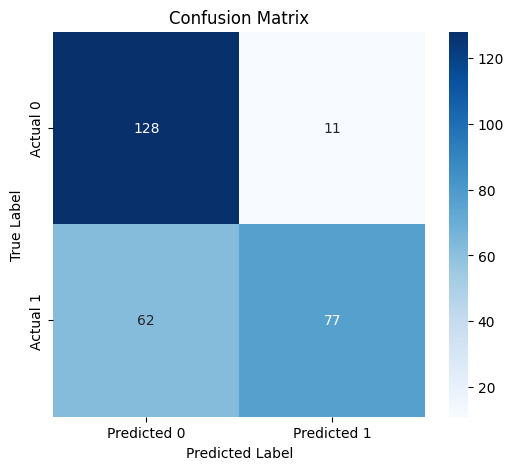

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming flat_true_labels and predicted_labels are defined as before

conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
